In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
import warnings
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')

# Exercise 1: FX realised volatility at various sampling frequencies
Compute realised volatilities of EURUSD at various sampling frequencies. What observations can you make? Do they converge to the same value? 

Method 2: 

$$\sigma = \sqrt{\sum r^2}$$

where:
- $r = \ln\frac{S_t}{S_{t-1}}  $

In [2]:
# Read EURUSD data
df = pd.read_csv("EURUSD.csv")
df["ts"] = pd.to_datetime(df["ts"])
df = df.set_index("ts")

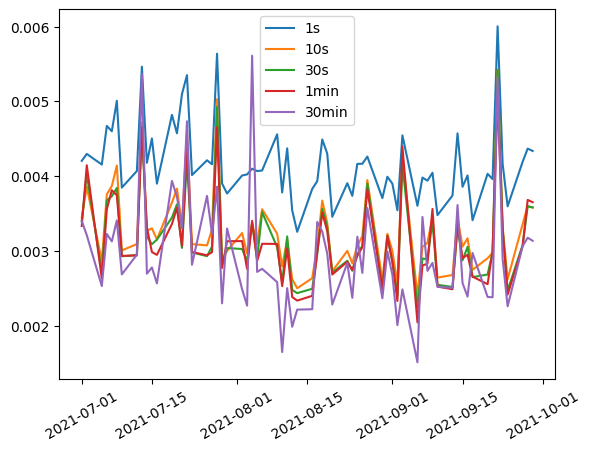

In [3]:
sampling_freq = ["1s", "10s", "30s", "1min", "30min"]

plt.figure(dpi = 100)
for freq in sampling_freq:
    
    df1 = df.resample(freq).last()
    df1 = df1[df1["spot"].notna()]
    df1["date"] = df1.index.date
    df1["log_ret"] = np.log(df1["spot"]/df1["spot"].shift(1))
    df1["log_ret_sqr"] = df1["log_ret"]**2
    df2 = df1.groupby("date")["log_ret_sqr"].sum().reset_index()
    df2.columns = ["date", "sum_log_ret_sqr"]
    df2 = df2.set_index("date")
    df2["realised_vol"] = np.sqrt(df2["sum_log_ret_sqr"])

    plt.plot(df2["realised_vol"], label = "{}".format(freq))
    
plt.xticks(rotation =30)
plt.legend()
plt.show()

In reality, FX realised volatility increases as sampling frequency increases. This is caused by market microstructure noise.

In [4]:
def realised_vol(series):
    return np.sqrt(np.sum(series**2))

In [5]:
freq = "5min"
df1 = df
df1["time_of_day"] = df1.index.ceil(freq).time
df1["log_ret"] = np.log(df1["spot"]/ df1["spot"].shift(1))

In [6]:
df2 = df1.groupby("time_of_day")["log_ret"].apply(realised_vol).reset_index()
df2.columns = ["time_of_day", "realised_vol"]
df2

,time_of_day,realised_vol
0,00:00:00,0.002214
1,00:05:00,0.001853
2,00:10:00,0.001669
3,00:15:00,0.001428
4,00:20:00,0.001627
...,...,...
283,23:35:00,0.001142
284,23:40:00,0.001038
285,23:45:00,0.001023
286,23:50:00,0.001095


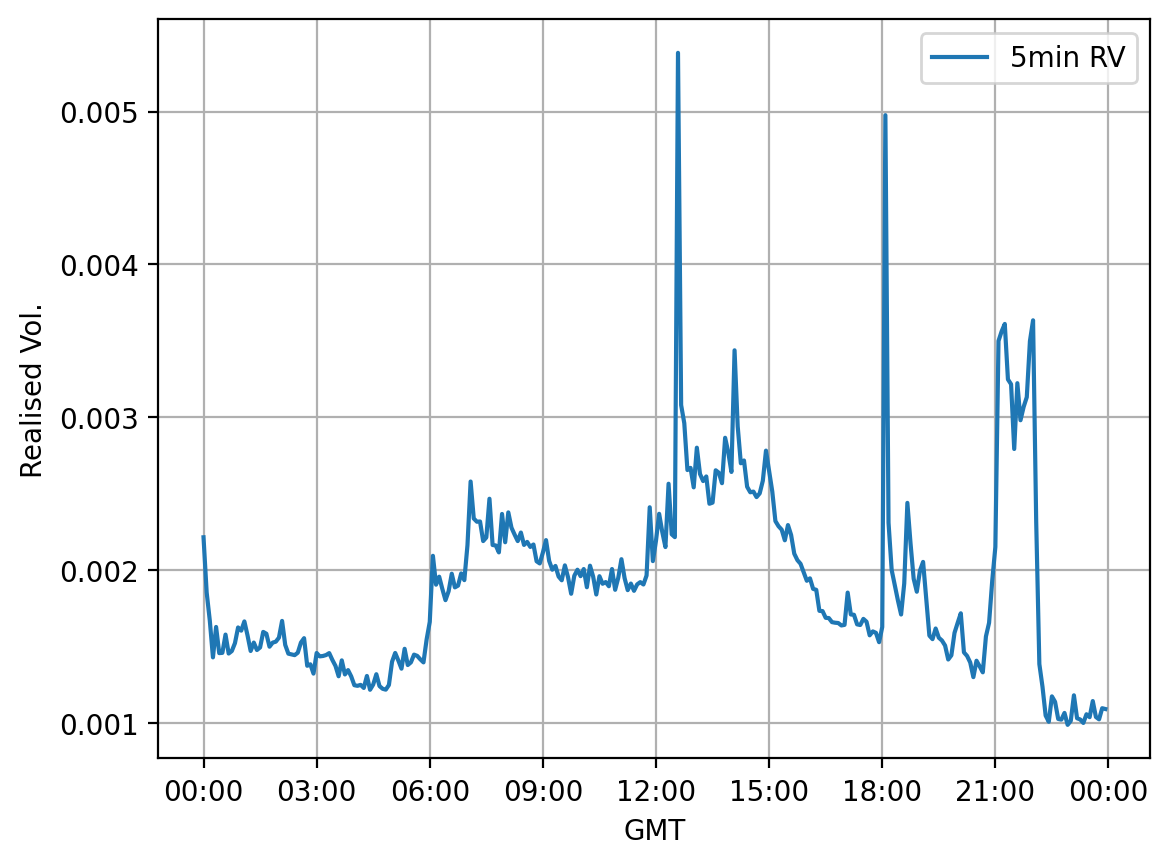

In [7]:
df3 = df2.groupby("time_of_day")["realised_vol"].mean().reset_index()
df3["time_of_day"] = pd.to_datetime("2021-12-24 " + df3["time_of_day"].astype("str"))


fig, ax  = plt.subplots(dpi = 200)
ax.plot(df3["time_of_day"], df3["realised_vol"], label = "{} RV".format(freq))
ax.set_xlabel("GMT")
ax.set_ylabel("Realised Vol.")
ax.legend()
ax.grid()
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.show()

# Exercise 2: Stationarity Check

Check stationarity of FX price series & its log-return series. 

In [8]:
def stationarity_test(series): 
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    
    if result[1] > 0.05: # non-stationary
        return False
    else:                # stationary
        return True

In [9]:
# Read EURUSD data
df = pd.read_csv("EURUSD.csv")
df["ts"] = pd.to_datetime(df["ts"])
df = df.set_index("ts")

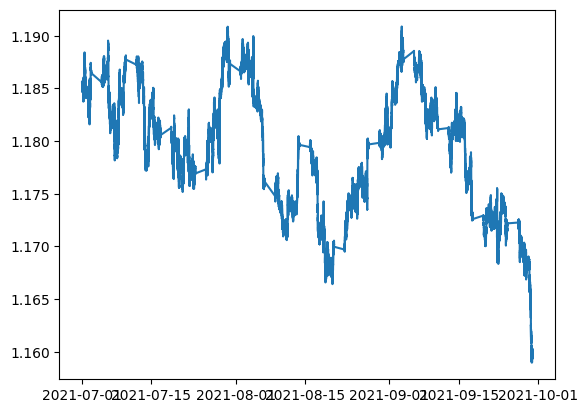

In [10]:
plt.plot(df["spot"])

In [11]:
stationarity_test(df["spot"].dropna().head(1000).values)

ADF Statistic: -0.884178
p-value: 0.793138


False

In [12]:
stationarity_test(np.log(df["spot"]/df["spot"].shift(1)).dropna().head(1000).values)

ADF Statistic: -12.178520
p-value: 0.000000


True

# Exercise 3: ACF & PACF plot for White Noise Series

In [13]:
white_noise = np.random.normal(0, 1, 1000)

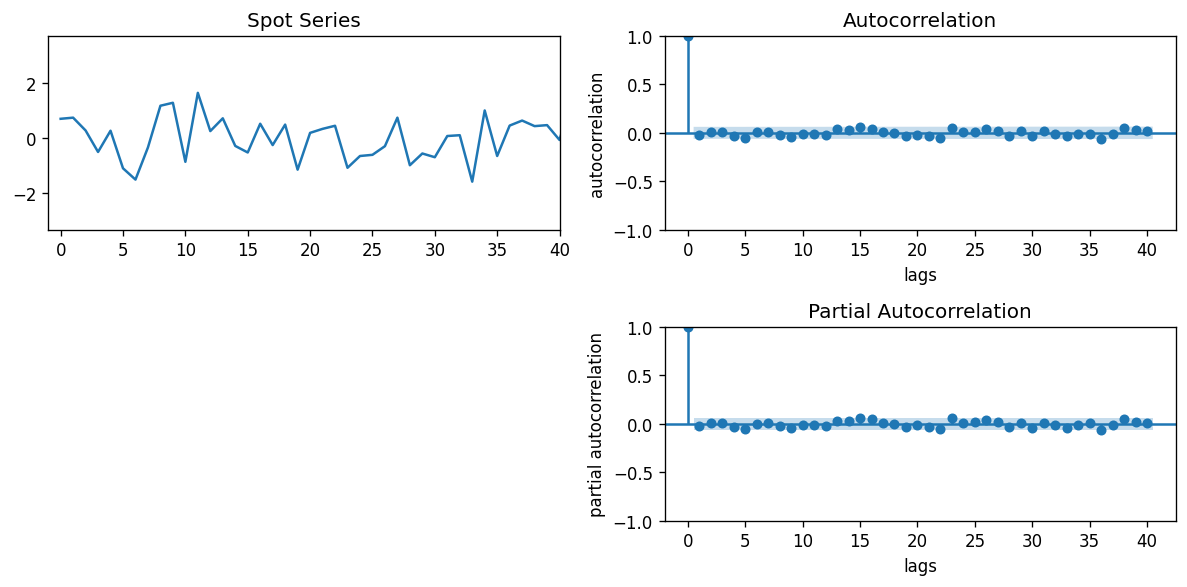

In [28]:
lags = 40
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(white_noise)
axes[0, 0].set_title('Spot Series')
axes[0, 0].set(xlim=(-1,lags))
plot_acf(white_noise, ax=axes[0, 1], lags = lags);

axes[0, 1].set_ylabel("autocorrelation")
axes[0, 1].set_xlabel("lags")
plot_pacf(white_noise, ax=axes[1, 1], lags = lags);
axes[1, 1].set_ylabel("partial autocorrelation")
axes[1, 1].set_xlabel("lags")

fig.delaxes(axes[1, 0])
fig.tight_layout()
plt.show()

# Exercise 4: ACF Plot & PACF Plot for AR and MA
Produce the ACF & PACF plots by using simulated data

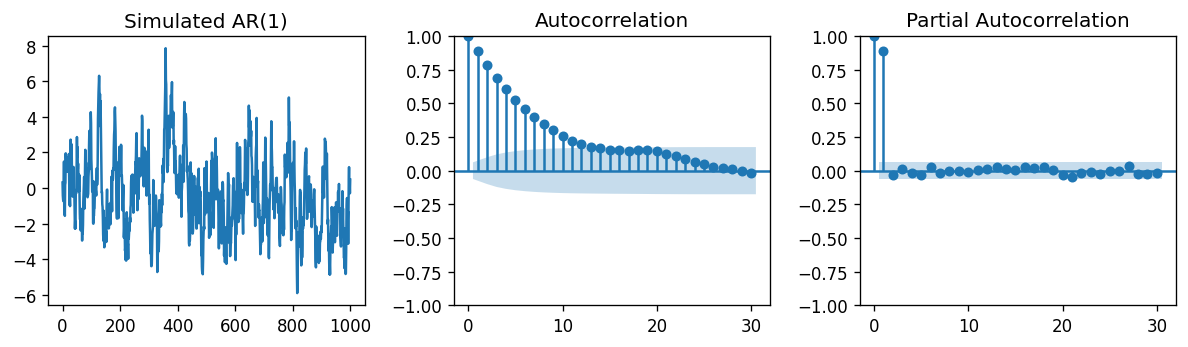

In [15]:
from statsmodels.tsa.arima_process import ArmaProcess
ARIMA1 = ArmaProcess([1, -0.9], [1])
simulated1 = ARIMA1.generate_sample(nsample=1000)
fig, axes = plt.subplots(1, 3, figsize = (10,3))
axes[0].plot(simulated1)
axes[0].set_title('Simulated AR(1)')
plot_acf(simulated1, ax = axes[1])
plot_pacf(simulated1, ax = axes[2])
fig.tight_layout()
plt.show()

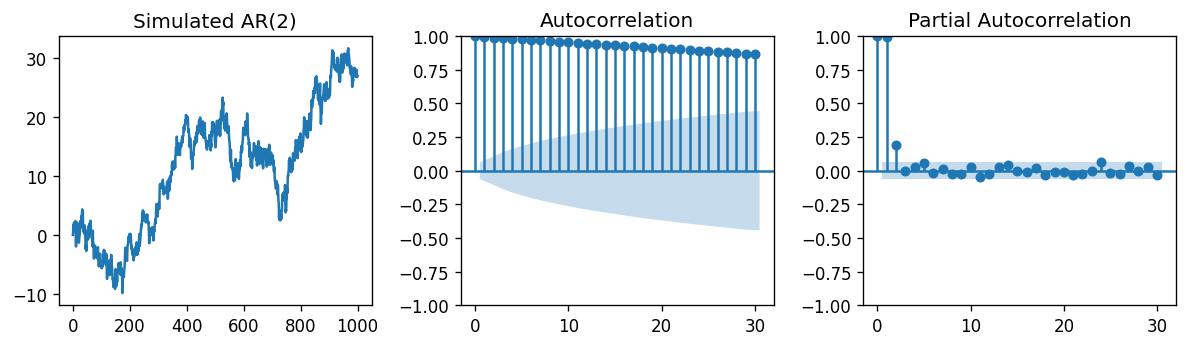

In [16]:
ARIMA2 = ArmaProcess([1, -0.8, -0.2], [1])
simulated2 = ARIMA2.generate_sample(nsample=1000)
fig, axes = plt.subplots(1, 3, figsize = (10,3))
axes[0].plot(simulated2)
axes[0].set_title('Simulated AR(2)')
plot_acf(simulated2, ax = axes[1])
plot_pacf(simulated2, ax = axes[2])
fig.tight_layout()
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1432.533
Date:                Wed, 08 Feb 2023   AIC                           2873.067
Time:                        09:18:35   BIC                           2892.698
Sample:                             0   HQIC                          2880.528
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.3102      7.511      1.506      0.132      -3.412      26.032
ar.L1          0.7872      0.030     26.429      0.000       0.729       0.846
ar.L2          0.2096      0.030      7.003      0.0

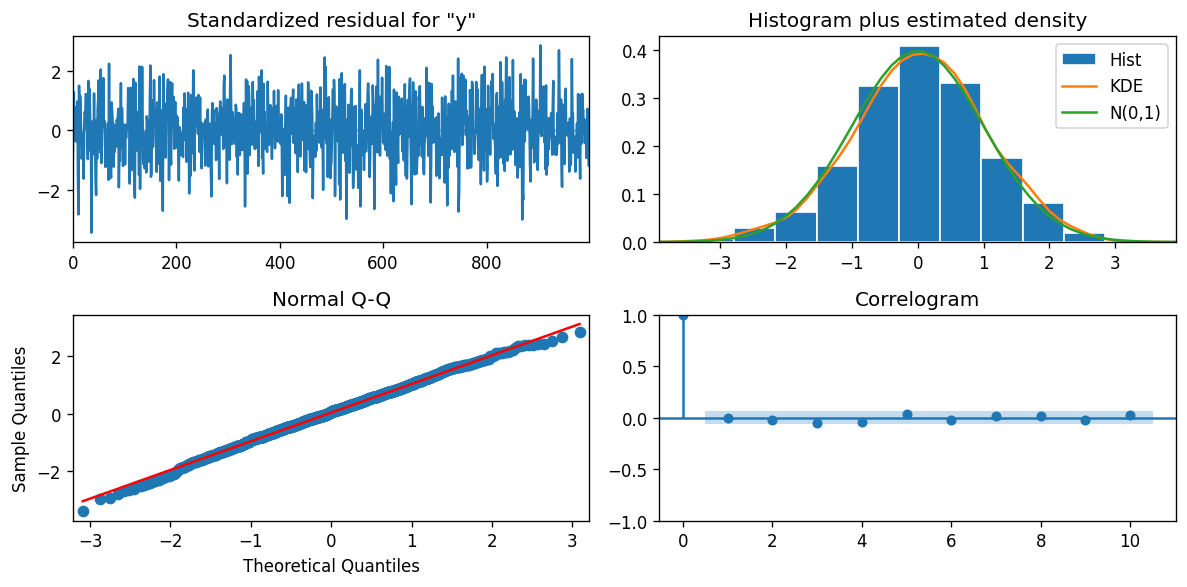

In [17]:
from statsmodels.tsa.arima.model import ARIMA
mod2 = ARIMA(simulated2, order=(2,0,0))
result2 = mod2.fit()
print(result2.summary())
result2.plot_diagnostics()
plt.tight_layout()
plt.show()

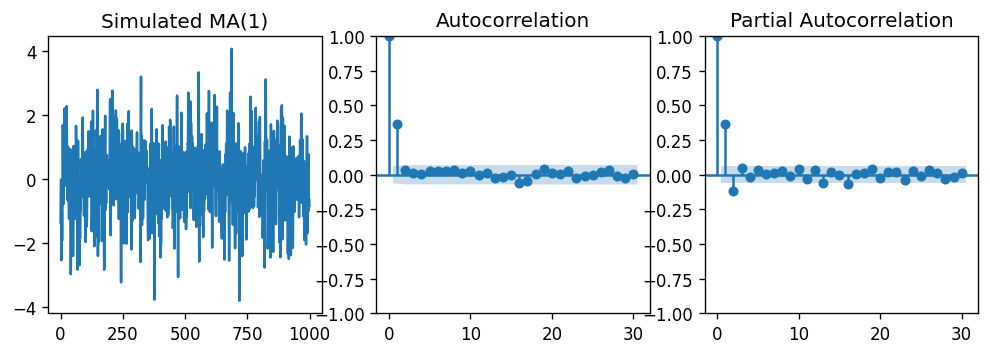

In [18]:
ARIMA3 = ArmaProcess([1], [1, 0.4])
simulated3 = ARIMA3.generate_sample(nsample=1000)
fig, axes = plt.subplots(1, 3, figsize = (10,3))
axes[0].plot(simulated3)
axes[0].set_title('Simulated MA(1)')
plot_acf(simulated3, ax = axes[1])
plot_pacf(simulated3, ax = axes[2])
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1433.483
Date:                Wed, 08 Feb 2023   AIC                           2872.966
Time:                        09:18:36   BIC                           2887.689
Sample:                             0   HQIC                          2878.562
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0243      0.045     -0.541      0.589      -0.113       0.064
ma.L1          0.4033      0.029     14.137      0.000       0.347       0.459
sigma2         1.0293      0.044     23.520      0.0

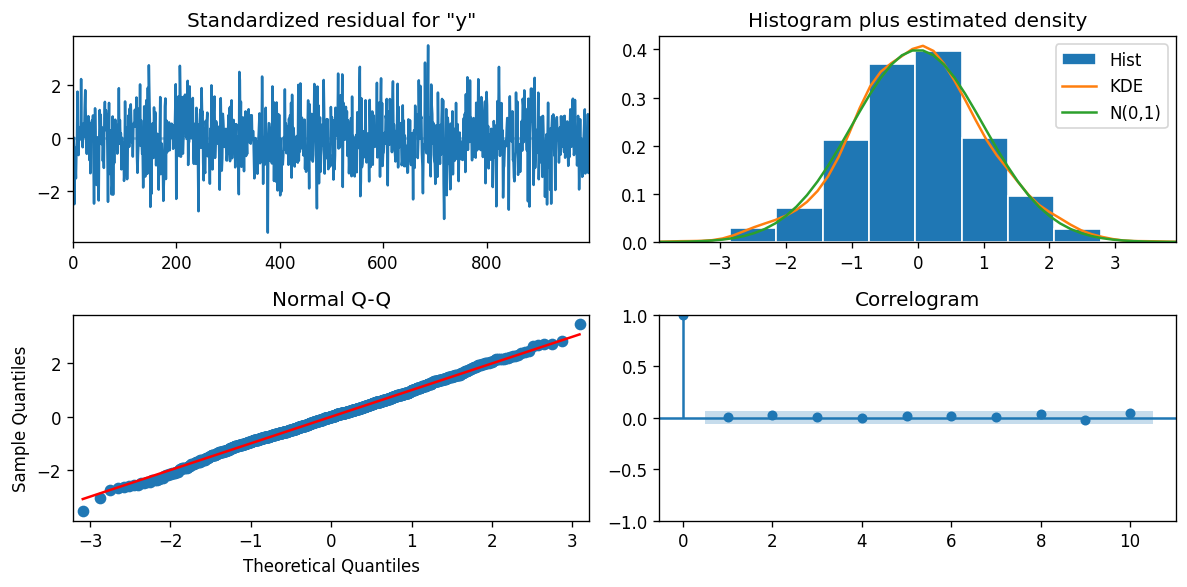

In [19]:
mod3 = ARIMA(simulated3, order=(0,0,1))
result3 = mod3.fit()
print(result3.summary())
result3.plot_diagnostics()
plt.tight_layout()
plt.show()

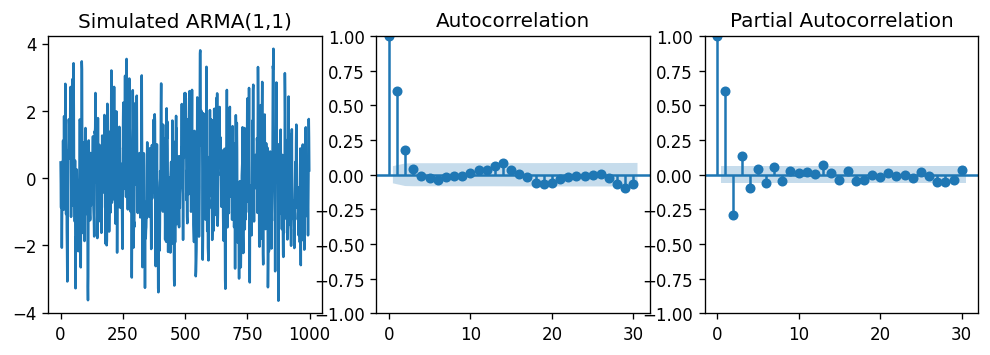

In [20]:
ARIMA4 = ArmaProcess([1, -0.4], [1, 0.4])
simulated4 = ARIMA4.generate_sample(nsample=1000)
fig, axes = plt.subplots(1, 3, figsize = (10,3))
axes[0].plot(simulated4)
axes[0].set_title('Simulated ARMA(1,1)')
plot_acf(simulated4, ax = axes[1])
plot_pacf(simulated4, ax = axes[2])
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1416.736
Date:                Wed, 08 Feb 2023   AIC                           2845.473
Time:                        09:18:37   BIC                           2874.919
Sample:                             0   HQIC                          2856.664
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0190      0.071     -0.269      0.788      -0.157       0.119
ar.L1         -0.3670      0.325     -1.130      0.258      -1.003       0.269
ar.L2          0.2323      0.082      2.833      0.0

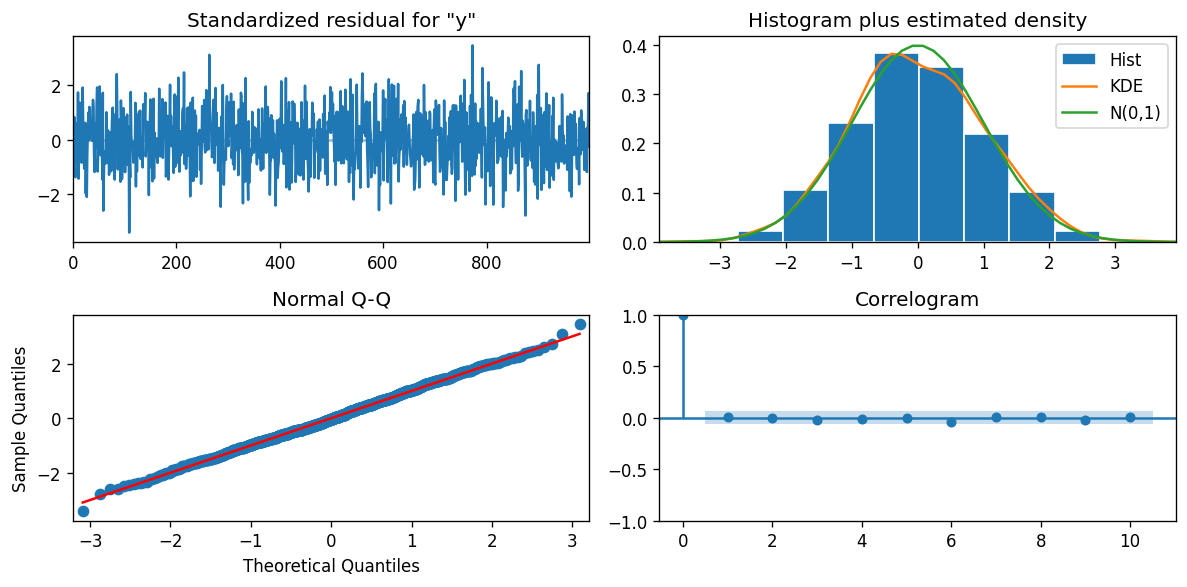

In [21]:
mod4 = ARIMA(simulated4, order=(2,0,2))
result4 = mod4.fit()
print(result4.summary())
result4.plot_diagnostics()
plt.tight_layout()
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1418.349
Date:                Wed, 08 Feb 2023   AIC                           2844.698
Time:                        09:18:38   BIC                           2864.329
Sample:                             0   HQIC                          2852.159
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0192      0.069     -0.278      0.781      -0.154       0.116
ar.L1          0.2829      0.044      6.433      0.000       0.197       0.369
ma.L1          0.5602      0.037     15.327      0.0

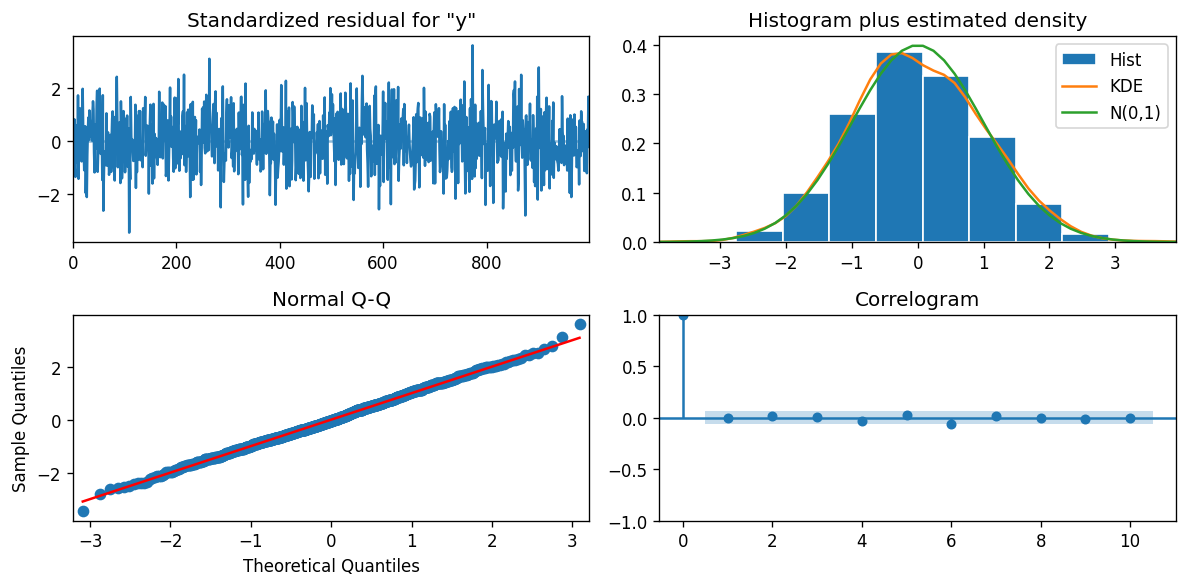

In [22]:
mod5 = ARIMA(simulated4, order=(1,0,1))
result5 = mod5.fit()
print(result5.summary())
result5.plot_diagnostics()
plt.tight_layout()
plt.show()

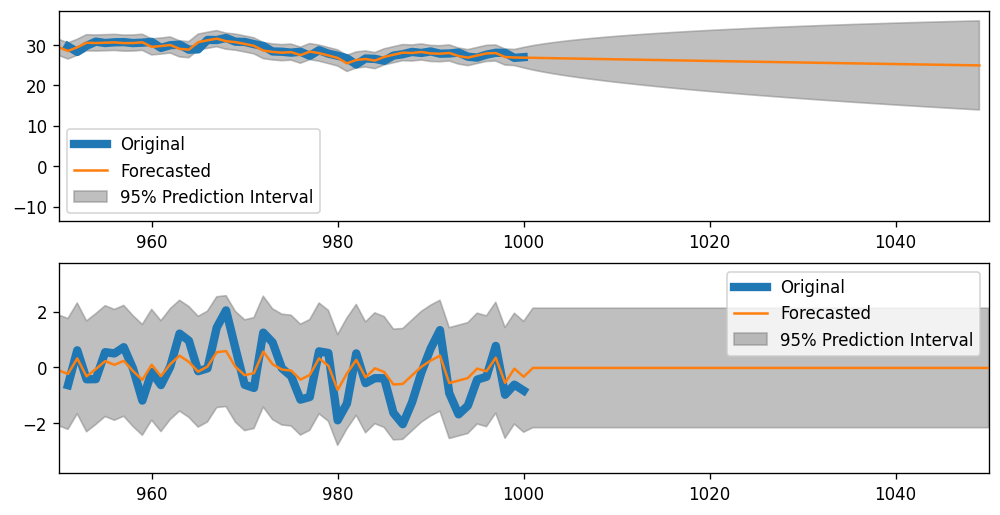

In [30]:
from statsmodels.graphics.tsaplots import plot_predict

fig, axes = plt.subplots(2, 1)
axes[0].plot(range(951,1001),simulated2[950:], linewidth = 5)
plot_predict(result2, start=1, end=1050, ax=axes[0])
axes[0].legend(["Original", "Forecasted", "95% Prediction Interval"])
axes[0].set(xlim=(950,1050))

axes[1].plot(range(951,1001),simulated3[950:], linewidth = 5)
plot_predict(result3, start=0, end=1050, ax=axes[1])
axes[1].legend(["Original", "Forecasted", "95% Prediction Interval"])
axes[1].set(xlim=(950,1050))
plt.show()

# Exercise 5: ACF Plot & PACF Plot for EURUSD
Produce the ACF & PACF plots for EURUSD data at the following frequencies: hourly, daily

In [24]:
# Read EURUSD data
df = pd.read_csv("EURUSD.csv")
df["ts"] = pd.to_datetime(df["ts"])
df = df.set_index("ts")

########### Sampling Frequency = H ###########


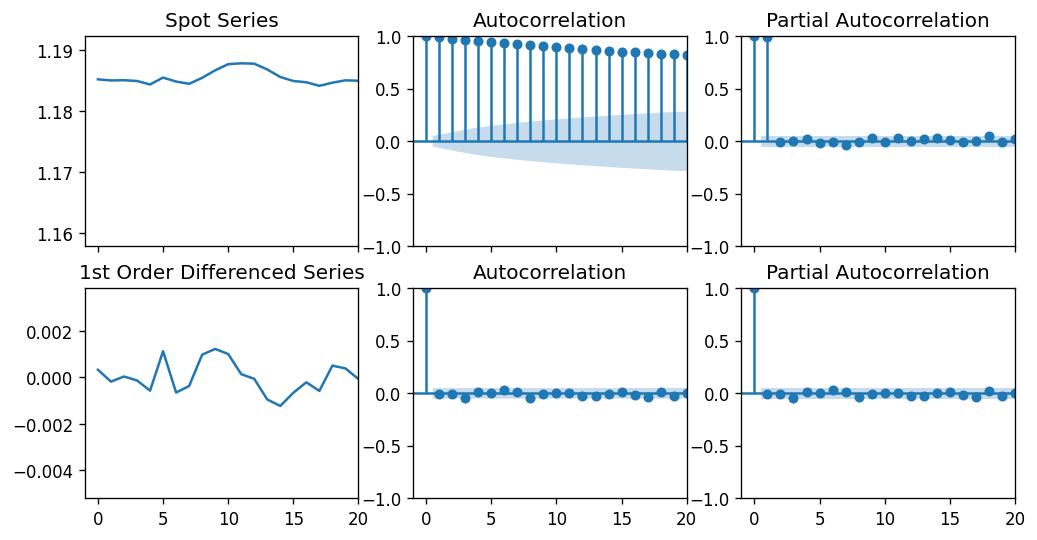

########### Sampling Frequency = D ###########


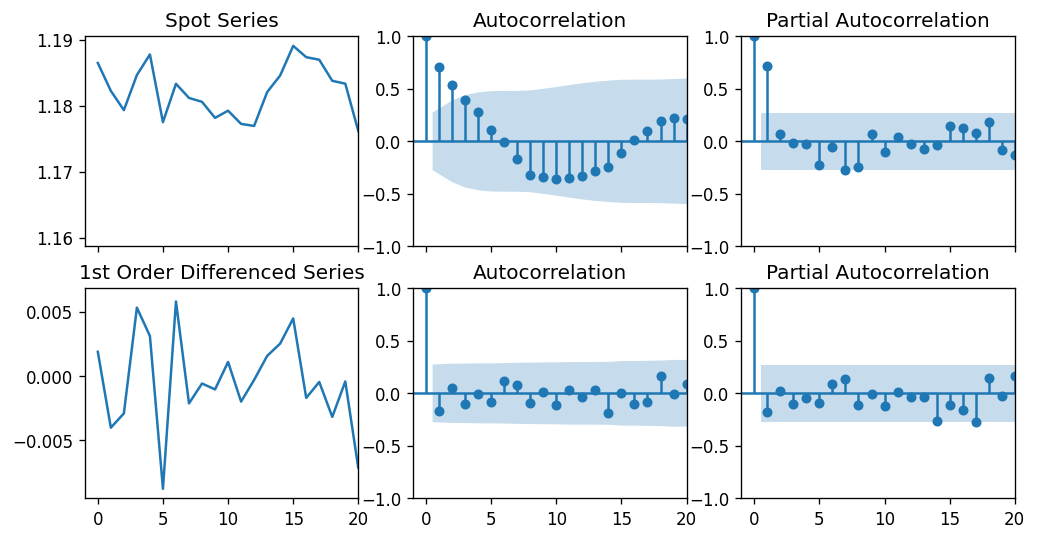

In [25]:
sampling_freq = ["H", "D"]
lags = 20
for freq in sampling_freq:
    print("########### Sampling Frequency = {} ###########".format(freq))
    df1 = df.resample(freq).last()
    df1["1st_diff"] = df1["spot"].diff()
    df1 = df1[df1["1st_diff"].notna()].reset_index()

    plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
    fig, axes = plt.subplots(2, 3, sharex=True)
    axes[0, 0].plot(df1["spot"])
    axes[0, 0].set_title('Spot Series')
    axes[0, 0].set(xlim=(-1,lags))
    plot_acf(df1["spot"], ax=axes[0, 1], lags = lags)
    plot_pacf(df1["spot"], ax=axes[0, 2], lags = lags)

    axes[1, 0].plot(df1["1st_diff"])
    axes[1, 0].set_title('1st Order Differenced Series')
    axes[1, 0].set(xlim=(-1, lags))
    plot_acf(df1["1st_diff"].dropna(), ax=axes[1, 1], lags = lags)
    plot_pacf(df1["1st_diff"].dropna(), ax=axes[1, 2], lags = lags)
    
    plt.show()

                               SARIMAX Results                                
Dep. Variable:                   spot   No. Observations:                   51
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 206.523
Date:                Wed, 08 Feb 2023   AIC                           -411.046
Time:                        09:18:45   BIC                           -409.134
Sample:                             0   HQIC                          -410.318
                                 - 51                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.509e-05   3.05e-06      4.952      0.000    9.12e-06    2.11e-05
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 0.83
Prob(Q):                              0.60   Pr

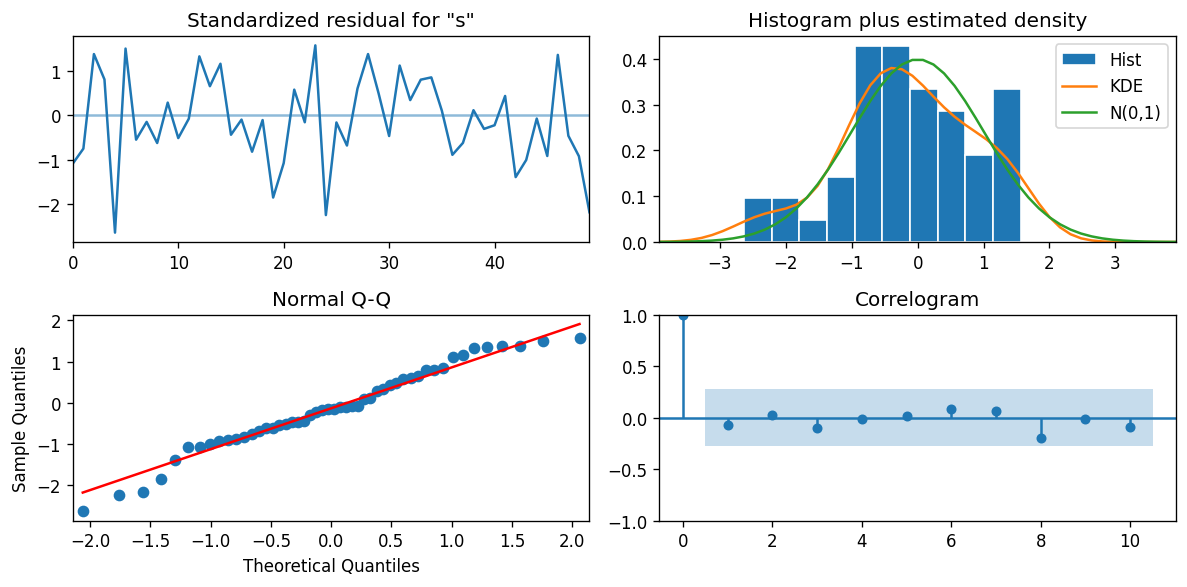

In [26]:
mod_ccy = ARIMA(df1["spot"], order=(0,1,0))
result_ccy = mod_ccy.fit()
print(result_ccy.summary())
result_ccy.plot_diagnostics()
plt.tight_layout()
plt.show()

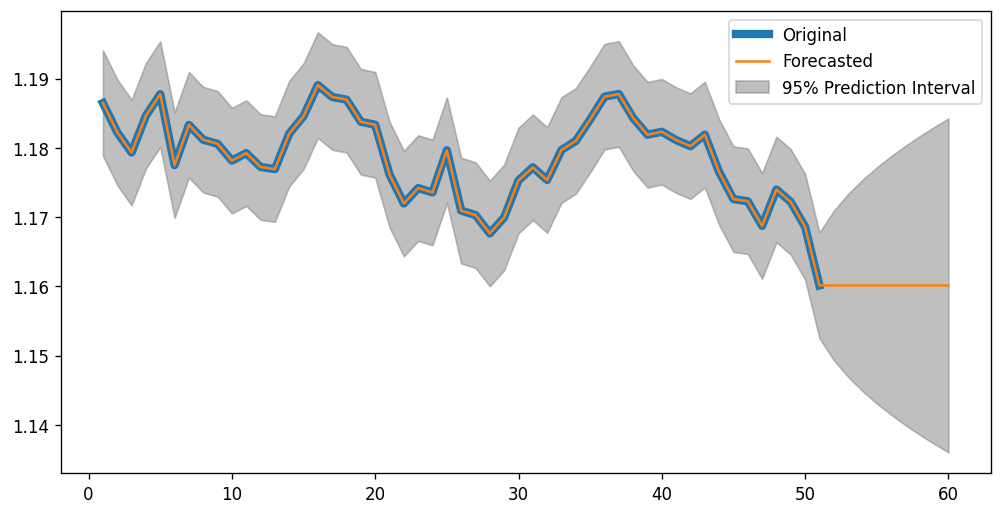

In [27]:
fig = plt.figure()
ax = fig.gca()
ax.plot(range(1,df1["spot"].shape[0]+1), df1["spot"], linewidth = 5)
plot_predict(result_ccy, start=1, end=60, ax=ax)
ax.legend(["Original", "Forecasted", "95% Prediction Interval"])
plt.show()